In [1]:
import numpy as np
import sys
import os
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../libs"))
sys.path.append(os.path.abspath("../utils"))

from plots.plots_tarefa5 import plot_interpolated_surface_with_original_data
from normalize import MinMaxNormalizer
from network import (
    hidden_forward,
    unflatten_weights,
    train_network,
)
from metrics import R2_score, MSE, MAE, RMSE
pd.set_option("display.float_format", "{:.5f}".format)

# Ajuste de curva por otimização

## Carregar os dados

In [2]:
# Carregamento dos dados
df = pd.read_excel("../data/Trabalho5dados.xlsx")
df.columns = ["x1", "x2", "y"]

df.head()

,x1,x2,y
0,17.50000,576.20000,848
1,35.90000,598.60000,905
2,31.40000,612.10000,578
3,23.70000,624.20000,382
4,20.20000,635.20000,298


### Mostrar superfície dos dados originais

In [3]:
grid_size = 100
x1_data, x2_data = df["x1"], df["x2"]
y_values = df["y"].values

fig_surface = plot_interpolated_surface_with_original_data(x1_data, x2_data, y_values, grid_size=grid_size)

## Pré-processamento dos dados

In [4]:
X = df[["x1", "x2"]]
y = df["y"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Criar os objetos para Padronização
scaler_full = MinMaxNormalizer(-1, 1)
scaler_y_full = MinMaxNormalizer(-1, 1)
scaler = MinMaxNormalizer(-1, 1)
scaler_y = MinMaxNormalizer(-1, 1)

# Ajusta os padronizadores aos dados
scaler_full.fit(X_train_full)
scaler_y_full.fit(y_train_full.to_frame())
scaler.fit(X_train)
scaler_y.fit(y_train.to_frame())

# Padroniza os dados
X_train_full_scaled = scaler_full.normalize(X_train_full)
X_train_scaled = scaler.normalize(X_train)
X_val_scaled = scaler.normalize(X_val)
X_test_scaled = scaler_full.normalize(X_test)

y_train_full_scaled = scaler_y_full.normalize(y_train_full.to_frame()).squeeze()
y_train_scaled = scaler_y.normalize(y_train.to_frame()).squeeze()
y_val_scaled = scaler_y.normalize(y_val.to_frame()).squeeze()
y_test_scaled = scaler_y_full.normalize(y_test.to_frame()).squeeze()

## Buscar melhores parâmetros para ajuste de curva

In [5]:
# Definir parâmetros da rede neural
n_iterations = 100
tolerance = 1e-9
alpha = 1e-3
range_neurons = range(2, 30)
range_epochs = range(1, 100)

best_epochs = None
best_neurons = None
n_epochs_with_no_improvement = 0
best_val_loss = float("-inf")  # Agora queremos maximizar R²
results_val = {}

# Inicializar listas para armazenar os pesos
neurons_weights = None

x1_train_scaled = X_train_scaled["x1"].values
x2_train_scaled = X_train_scaled["x2"].values

x1_val_scaled = X_val_scaled["x1"].values
x2_val_scaled = X_val_scaled["x2"].values

np.random.seed(42)

for n_neurons in range_neurons:
    results_val[n_neurons] = []
    for n_epochs in range_epochs:
        #print(f"Treinando rede com {n_neurons} neurônios e {n_epochs} épocas...")
        # treinar a rede neural
        neurons_weights_flat, _, _ = train_network(X1=x1_train_scaled, X2=x2_train_scaled, y=y_train_scaled,
                    n_neurons=n_neurons, n_epochs=n_epochs,
                    n_iterations_per_epoch=n_iterations, tolerance=tolerance, alpha=alpha)

        # Desempacotar os pesos finais
        neurons_weights = unflatten_weights(
            neurons_weights_flat, n_inputs=2, n_neurons=n_neurons
        )

        # Fazer previsão usando a rede treinada
        y_hat_scaled = hidden_forward(
            x1_val_scaled, x2_val_scaled, neurons_weights=neurons_weights, activation_fn=np.tanh
        )

        # Convertendo para DataFrame com o mesmo índice usado no treinamento
        y_hat = scaler_y.denormalize(y_hat_scaled.reshape(-1, 1)).flatten()

        mse_final = MSE(y_val.values, y_hat)
        r2_final = R2_score(y_val.values, y_hat)

        results_val[n_neurons].append({'n_epochs': n_epochs, 'mse': mse_final, 'r2': r2_final})

        # compara o R² para decidir se é o melhor modelo até agora
        if r2_final > best_val_loss:
            best_val_loss = r2_final
            best_neurons = n_neurons
            best_epochs = n_epochs
            n_epochs_with_no_improvement = 0
        else:
            n_epochs_with_no_improvement += 1
            if n_epochs_with_no_improvement >= 5:
                break

num_neurons = best_neurons
num_epochs = best_epochs
print(f"Melhor número de neurônios: {num_neurons} com R² de validação: {best_val_loss:.6f}")
print(f"Número de épocas: {num_epochs}")

Melhor número de neurônios: 22 com R² de validação: 0.996818
Número de épocas: 7


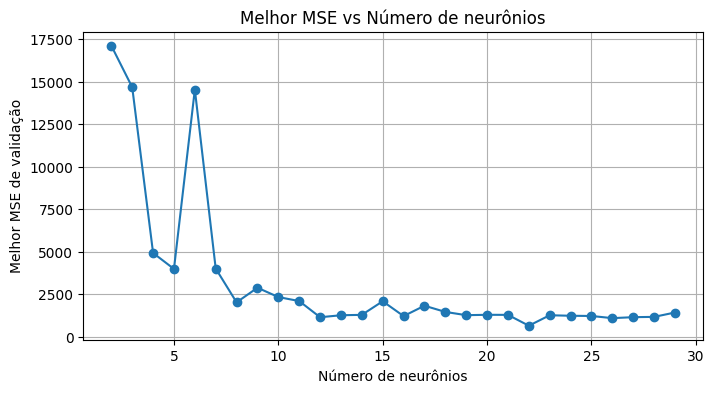

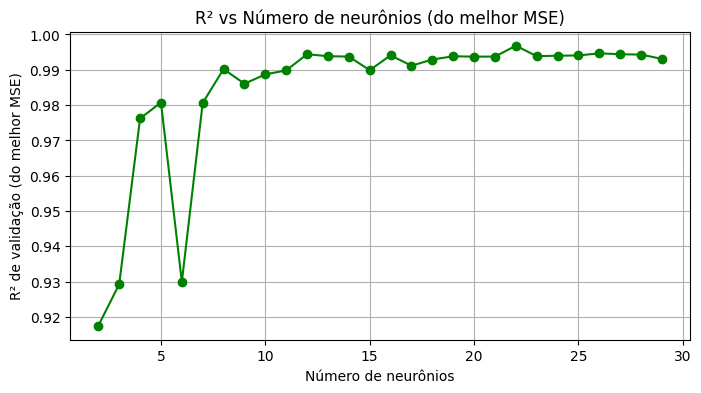

In [6]:
neurons = []
mses = []
r2s = []

for n, res_list in results_val.items():
    best_res_mse = min(res_list, key=lambda x: x['mse'])
    best_res_r2 = max(res_list, key=lambda x: x['r2'])
    neurons.append(n)
    mses.append(best_res_mse['mse'])
    r2s.append(best_res_r2['r2'])

# Plot MSE vs número de neurônios (usando o melhor mse de cada neurônio)
plt.figure(figsize=(8, 4))
plt.plot(neurons, mses, marker='o')
plt.xlabel('Número de neurônios')
plt.ylabel('Melhor MSE de validação')
plt.title('Melhor MSE vs Número de neurônios')
plt.grid(True)
plt.show()

# Plot R² vs número de neurônios (usando o r2 do melhor mse)
plt.figure(figsize=(8, 4))
plt.plot(neurons, r2s, marker='o', color='green')
plt.xlabel('Número de neurônios')
plt.ylabel('R² de validação (do melhor MSE)')
plt.title('R² vs Número de neurônios (do melhor MSE)')
plt.grid(True)
plt.show()

### Rodar os experimentos

In [7]:
x1_train_full_scaled = X_train_full_scaled["x1"].values
x2_train_full_scaled = X_train_full_scaled["x2"].values

x1_test_scaled = X_test_scaled["x1"].values
x2_test_scaled = X_test_scaled["x2"].values

neurons_weights_flat, _, _ = train_network(X1=x1_train_full_scaled, X2=x2_train_full_scaled, y=y_train_full_scaled,
                    n_neurons=num_neurons, n_epochs=num_epochs,
                    n_iterations_per_epoch=n_iterations, tolerance=tolerance, alpha=alpha)

# Desempacotar os pesos finais
neurons_weights = unflatten_weights(
    neurons_weights_flat, n_inputs=2, n_neurons=num_neurons
)

# Fazer previsão usando a rede treinada
y_hat_scaled = hidden_forward(
    x1_test_scaled, x2_test_scaled, neurons_weights=neurons_weights, activation_fn=np.tanh
)

# Convertendo para DataFrame com o mesmo índice usado no treinamento
y_hat = scaler_y_full.denormalize(y_hat_scaled.reshape(-1, 1)).flatten()

## Resultados

In [8]:
# Calcular métricas
mse_final = MSE(y_test.values, y_hat)
rmse_final = RMSE(y_test.values, y_hat)
mae_final = MAE(y_test.values, y_hat)
r2_final = R2_score(y_test.values, y_hat)

# Preparar resultados para exibição
dict_results = {
    "Feature_Set": "MinMax(-1,1)",
    "epochs": num_epochs,
    "neurons": num_neurons,
    "Loss_Function": "MSE",
    "MSE_Final": mse_final,
    "RMSE_Final": rmse_final,
    "MAE_Final": mae_final,
    "R2_Final": r2_final
}

""" # Adiciona os pesos de cada neurônio em colunas separadas
for i, weights in enumerate(neurons_weights[:-1]):  # Exclui o neurônio de saída
    dict_results[f"Pesos_Neuronio_{i + 1}"] = [float(f"{w:.6f}") for w in weights]

# Adiciona os pesos do neurônio de saída
dict_results["Pesos_Neuronio_Saida"] = [
    float(f"{w:.6f}") for w in neurons_weights[-1]
] """

df_result = pd.DataFrame([dict_results])
df_result

,Feature_Set,epochs,neurons,Loss_Function,MSE_Final,RMSE_Final,MAE_Final,R2_Final
0,"MinMax(-1,1)",7,22,MSE,664.24287,25.77291,16.54125,0.99687


In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=37)

mse_scores = []
r2_scores = []

for train_idx, val_idx in kf.split(X):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    scaler_cv = MinMaxNormalizer(-1, 1)
    scaler_y_cv = MinMaxNormalizer(-1, 1)
    scaler_cv.fit(X_train_cv)
    scaler_y_cv.fit(y_train_cv.to_frame())

    X_train_cv_scaled = scaler_cv.normalize(X_train_cv)
    X_val_cv_scaled = scaler_cv.normalize(X_val_cv)
    y_train_cv_scaled = scaler_y_cv.normalize(y_train_cv.to_frame()).squeeze()
    y_val_cv_scaled = scaler_y_cv.normalize(y_val_cv.to_frame()).squeeze()

    X1_train_cv = X_train_cv_scaled["x1"].values
    X2_train_cv = X_train_cv_scaled["x2"].values
    X1_val_cv = X_val_cv_scaled["x1"].values
    X2_val_cv = X_val_cv_scaled["x2"].values

    neurons_weights_flat, _, _ = train_network(X1=X1_train_cv, X2=X2_train_cv, y=y_train_cv_scaled,
                    n_neurons=num_neurons, n_epochs=num_epochs,
                    n_iterations_per_epoch=n_iterations, tolerance=tolerance, alpha=alpha)

    # Desempacotar os pesos finais
    neurons_weights = unflatten_weights(
        neurons_weights_flat, n_inputs=2, n_neurons=num_neurons
    )

    # Fazer previsão usando a rede treinada
    y_hat_cv_raw = hidden_forward(
        X1_val_cv, X2_val_cv, neurons_weights=neurons_weights, activation_fn=np.tanh
    )

    # Convertendo para DataFrame com o mesmo índice usado no treinamento
    y_hat_cv = scaler_y_cv.denormalize(y_hat_cv_raw.reshape(-1, 1)).flatten()
    mse_scores.append(MSE(y_val_cv.values, y_hat_cv))
    r2_scores.append(R2_score(y_val_cv.values, y_hat_cv))

print("\nResultados de Validação Cruzada:")
print("MSEs por fold:", [f"{float(mse):.3f}" for mse in mse_scores])
print("R²s por fold:", [f"{float(r2):.3f}" for r2 in r2_scores])
print(f"Média MSE: {float(np.mean(mse_scores)):.3f}")
print(f"Média R²: {float(np.mean(r2_scores)):.3f}")


Resultados de Validação Cruzada:
MSEs por fold: ['777.908', '876.762', '1366.872', '488.658', '997.750']
R²s por fold: ['0.997', '0.996', '0.994', '0.998', '0.995']
Média MSE: 901.590
Média R²: 0.996


In [10]:
num_epochs, num_neurons

(7, 22)

In [11]:
x1_test = X_test["x1"].values
x2_test = X_test["x2"].values

# Criar grade para visualizar a predição
x1_grid = np.linspace(min(x1_test), max(x1_test), grid_size)
x2_grid = np.linspace(min(x2_test), max(x2_test), grid_size)
x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)
points = np.column_stack((x1_test, x2_test))

y_hat_grid = griddata(points, y_hat, (x1_mesh, x2_mesh), method="cubic")

""" # Adicionar superfície prevista
fig_surface.add_trace(go.Surface(
    x=x1_grid,
    y=x2_grid,
    z=y_hat_grid,
    colorscale='Reds',
    opacity=0.7,
    showscale=True,
    name='Superfície Prevista'
)) """

# Adicionar os pontos previstos
fig_surface.add_trace(
    go.Scatter3d(
        x=x1_test,
        y=x2_test,
        z=y_hat,
        mode="markers",
        marker=dict(
            size=4,
            color="blue",
        ),
        name="Predições",
    )
)

fig_surface.update_layout(
    title="Comparação entre Dados Originais e Previstos",
)

fig_surface.show()